Tree-based models, like decision trees, random forests, and boosting algorithms (e.g., XGBoost, LightGBM, CatBoost), benefit significantly from hyperparameter optimization. Tools like `GridSearchCV`, `RandomizedSearchCV`, and `cross_val_score` in scikit-learn enable robust tuning via cross-validation, similar to linear or logistic regression models. Below, we explore these tools and smarter alternatives for complex models.

## Cross-Validation Basics

- `cross_val_score`: Evaluates a model’s performance for a fixed set of hyperparameters using cross-validation. Requires manual loops to search over hyperparameter combinations, making it labor-intensive for extensive tuning.

- `GridSearchCV` and `RandomizedSearchCV`: Automate hyperparameter search with built-in cross-validation, internally handling loops to evaluate combinations efficiently.


## `GridSearchCV`: Exhaustive but Limited

`GridSearchCV` performs an **exhaustive search** over a predefined grid of hyperparameter values.

- **Pros**:
  - Guarantees finding the best combination within the specified grid.
  - Ideal for small, well-defined search spaces (e.g., tuning `max_depth=[3, 5, 7]` and `n_estimators=[100, 200]`).
  
- **Cons**:
  - Requires **discrete lists** for each hyperparameter, unable to sample from continuous distributions.
  - Grid size grows **exponentially** with more hyperparameters, making it **computationally infeasible** for complex models like boosting trees (e.g., XGBoost with 5+ hyperparameters).
  - Time-consuming, especially for large datasets or slow models.

**Use Case**: Best for simple models or when you have a small, targeted set of hyperparameter values.


## `RandomizedSearchCV`: Efficient but Random

`RandomizedSearchCV` samples a fixed number of hyperparameter combinations (`n_iter`) randomly from user-defined distributions.

- **Pros**:
  - **More efficient** than `GridSearchCV` for large search spaces, as it evaluates fewer combinations.
  - Supports **continuous distributions** (e.g., `scipy.stats.loguniform` for learning rate), offering greater flexibility.
    ``` python
    from scipy.stats import uniform
    'learning_rate': uniform(loc=0.01, scale=0.3),  # Range: [0.01, 0.31)
    ```
  - **Faster**, as it avoids exhaustive enumeration.

- **Cons**:
  - Random sampling may **miss optimal regions**, especially in high-dimensional spaces or with limited iterations.
  - Performance depends on the choice of `n_iter` and distribution quality.

**Use Case**: Preferred for **initial exploration** or when **computational resources are limited** but the search space is large.

  

## Challenges with Boosting Models

Boosting models (e.g., Gradient Boosting, XGBoost, LightGBM) are powerful but have **many hyperparameters** (e.g., learning rate, max depth, number of estimators, regularization terms). This complexity makes `GridSearchCV` impractical and `RandomizedSearchCV` suboptimal, as random sampling can be inefficient in high-dimensional spaces.


## Smarter Alternatives for Complex Models

For boosting models, neural networks, or other high-dimensional algorithms, intelligent optimization methods outperform traditional approaches by efficiently exploring the hyperparameter space. Here are the top alternatives:

### 1. `BayesSearchCV` (Bayesian Optimization)

- **How it works**: Uses a probabilistic surrogate model (e.g., Gaussian Process) to predict promising hyperparameter combinations based on past evaluations.
  
- **Advantages**:
  
  - Converges faster than random search by focusing on high-performing regions.
  - It works natively with scikit-learn pipelines, simplifying tuning for workflows with preprocessing
  - GP (Gassian Process) - based optimization is effective for smooth, continuous hyperparameters (e.g., learning rate, regularization), converging faster in low-dimensional spaces (Tuning 2-5 continuous parameters).
  - Ideal for produnction environment restricted to scikit-learn extensions
  
- **Library**: `scikit-optimize` or `bayes_opt`.

- **Use Case**: Ideal for **small to medium** search spaces with **continuous parameters** on **small to medium-sized** datasets.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from xgboost import XGBRegressor, XGBClassifier
import seaborn as sns
import plotly

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_objective, plot_histogram, plot_convergence
import warnings
from IPython import display

In [2]:
# Load the dataset
car = pd.read_csv('Datasets/car.csv')
car.head()

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,vw,Beetle,2014,Manual,55457,Diesel,30,65.3266,1.6,7490
1,vauxhall,GTC,2017,Manual,15630,Petrol,145,47.2049,1.4,10998
2,merc,G Class,2012,Automatic,43000,Diesel,570,25.1172,3.0,44990
3,audi,RS5,2019,Automatic,10,Petrol,145,30.5593,2.9,51990
4,merc,X-CLASS,2018,Automatic,14000,Diesel,240,35.7168,2.3,28990


In [5]:
X = car.drop(columns=['price'])
y = car['price']

# extract the categorical columns and put them in a list
categorical_feature = X.select_dtypes(include=['object']).columns.tolist()

# extract the numerical columns and put them in a list
numerical_feature = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# convert the categorical columns to category type
for col in categorical_feature:
    X[col] = X[col].astype('category')


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# build a baseline xgboost model
xgb = XGBRegressor(objective='reg:squarederror', enable_categorical=True, random_state=42)
# fit the model
xgb.fit(X_train, y_train, )
# make predictions
y_pred = xgb.predict(X_test)

print ('Baseline Model: ')
# calculate the RMSE
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse}')
# calculate the R2 score
r2 = r2_score(y_test, y_pred)
print(f'R2: {r2}')

Baseline Model: 
RMSE: 3299.648193359375
R2: 0.9628884792327881


Let's use BayesSearchCV to boost its performance

In [7]:
%%time
# define the search space for Bayesian optimization
search_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(5, 30),
    'learning_rate': Real(0.01, 0.3, prior='uniform'),
    'subsample': Real(0.5, 1.0, prior='uniform'),
    'colsample_bytree': Real(0.5, 1.0, prior='uniform'),
    'gamma': Real(0, 5, prior='uniform'),
}

# define the model
xgb = XGBRegressor(objective='reg:squarederror', enable_categorical=True, random_state=42)
# define the Bayesian optimization search
bayes_search = BayesSearchCV(
    xgb,
    search_space,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
# fit the model
bayes_search.fit(X_train, y_train)

CPU times: total: 46.6 s
Wall time: 3min 24s


BayesSearchCV(cv=3,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None...
                             'gamma': Real(low=0, high=5, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=0.3, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=5, high=30, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [ ]:
print('Bayesian Optimization Results: ')
# get the best parameters
best_params_bayes = bayes_search.best_params_
print('Best Parameters: ')
print(best_params_bayes)
# get the best score
best_score_bayes = bayes_search.best_score_
print('Best CV Score: ', best_score_bayes)
# make predictions
y_pred_bayes = bayes_search.predict(X_test)
# calculate the RMSE
rmse_bayes = root_mean_squared_error(y_test, y_pred_bayes)
print('Test RMSE: ', rmse_bayes)
# calculate the R2 score
r2_bayes = r2_score(y_test, y_pred_bayes)
print('Test R2: ', r2_bayes)

Bayesian Optimization Results: 
Best Parameters: 
OrderedDict({'colsample_bytree': 0.7800962787418171, 'gamma': 5.0, 'learning_rate': 0.03253670126492928, 'max_depth': 5, 'n_estimators': 342, 'subsample': 0.5})
Best CV Score:  -3061.9464518229165
Test RMSE:  3236.476318359375
Test R2:  0.9642958641052246



### Visualizing `BayesSearchCV` Results

Visualizing `BayesSearchCV` outcomes helps interpret the hyperparameter optimization process for tree-based models like **XGBoost**. Visualization can provide critical insights into convergence, parameter impact, and model behavior, helping you understand and refine model behavior.

**Key Benefits of Visualization:**

- **Check Convergence**:  
  Plot best scores vs. iterations to determine if the search has stabilized or requires more trials.

- **Identify Key Parameters**:  
  Use scatter plots to reveal which hyperparameters (e.g., `learning_rate`) significantly influence performance.

- **Explore Interactions**:  
  Use heatmaps or contour plots to examine relationships between hyperparameters (e.g., `learning_rate` vs. `max_depth`).

- **Diagnose Issues**:  
  Spot poor search regions or insufficient iterations through patterns in the plots.

**Practical Tips**

- **Plots**:  
  Use convergence, scatter, heatmap, or parallel coordinate plots with libraries like **Matplotlib** or **Seaborn**.

- **Accessing Results**:  
  Extract tuning history from the `cv_results_` attribute of the `BayesSearchCV` object for plotting.




Let's plot the convergence first

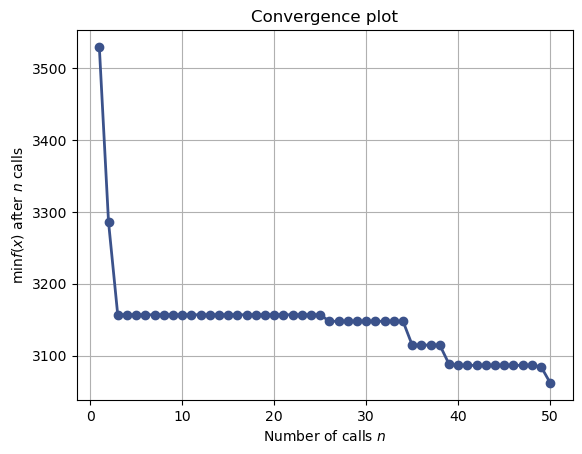

In [13]:
from skopt.plots import plot_convergence, plot_objective

# plot the convergence
bayes_res = bayes_search.optimizer_results_[0]
plot_convergence(bayes_res)
plt.show()

In [14]:
# the raw objective values at each iteration
func_vals = np.array(bayes_res.func_vals)

# the best objective value found so far
best_val = func_vals.min()

# All iterations (1-based) that hit that minimum
best_iters = np.where(func_vals == best_val)[0] + 1

print(f"Best objective = {best_val:.4f}")
print(f"Reached at iteration(s): {best_iters.tolist()}")

Best objective = 3061.9465
Reached at iteration(s): [50]


* `func_vals` is an array of length `n_iter`, one entry per call.

* We use `argmin/min` because by default BayesSearchCV minimizes the underlying surrogate objective (here negative MAE).

* If you’re maximizing some metric, either negate func_vals or look at -best_val appropriately.

Let's plot the objective next

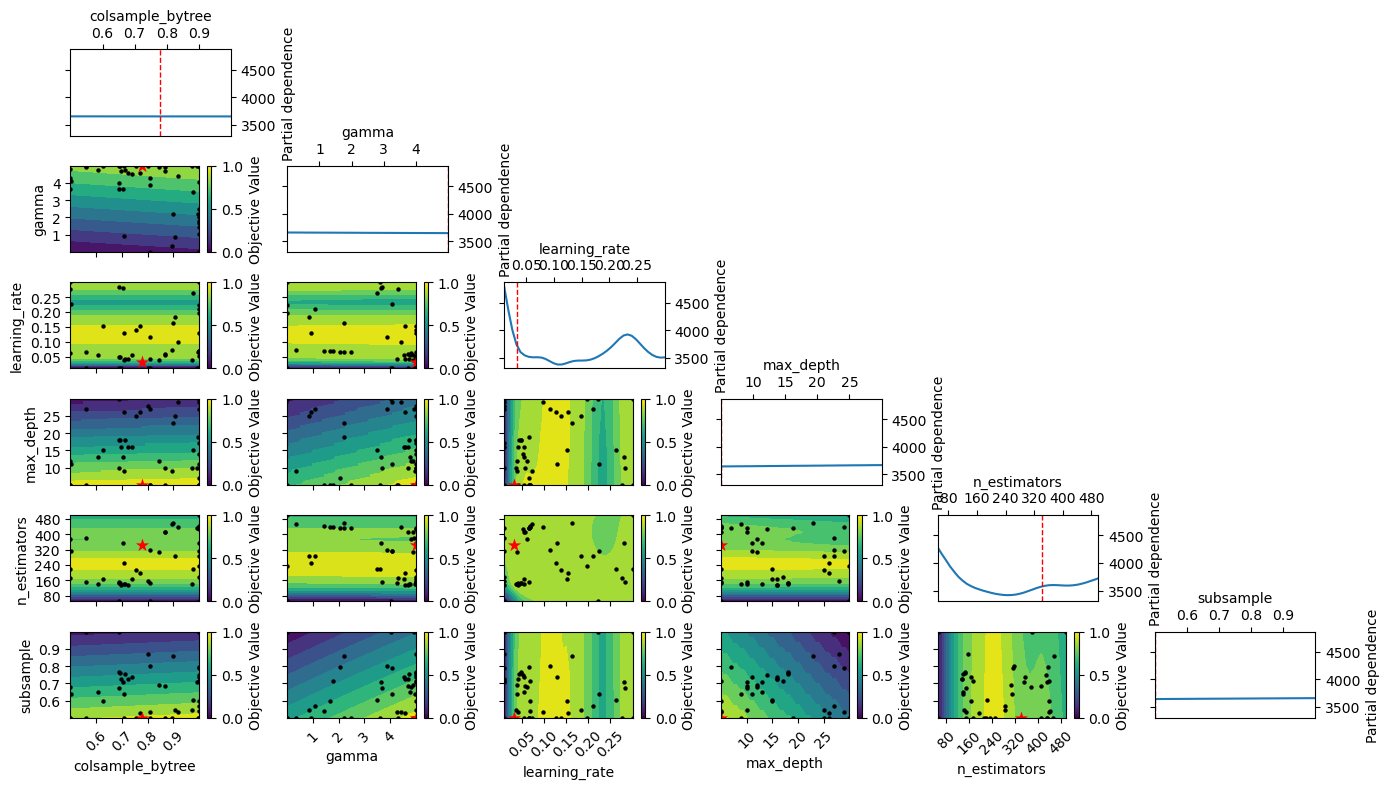

In [15]:
# Plot and store the figure and axes
fig, ax = plt.subplots(figsize=(14, 8))
result = plot_objective(bayes_search.optimizer_results_[0], ax=ax)

# Find contour plots in all the axes
for i, ax in enumerate(fig.get_axes()):
    # Look for collections in each axis
    for collection in ax.collections:
        if isinstance(collection, plt.matplotlib.collections.QuadMesh) or \
           isinstance(collection, plt.matplotlib.collections.PathCollection):
            # Add colorbar for this collection
            cbar = fig.colorbar(collection, ax=ax)
            cbar.set_label('Objective Value')
            break

plt.tight_layout()
plt.show()

Let's plot evalutions next

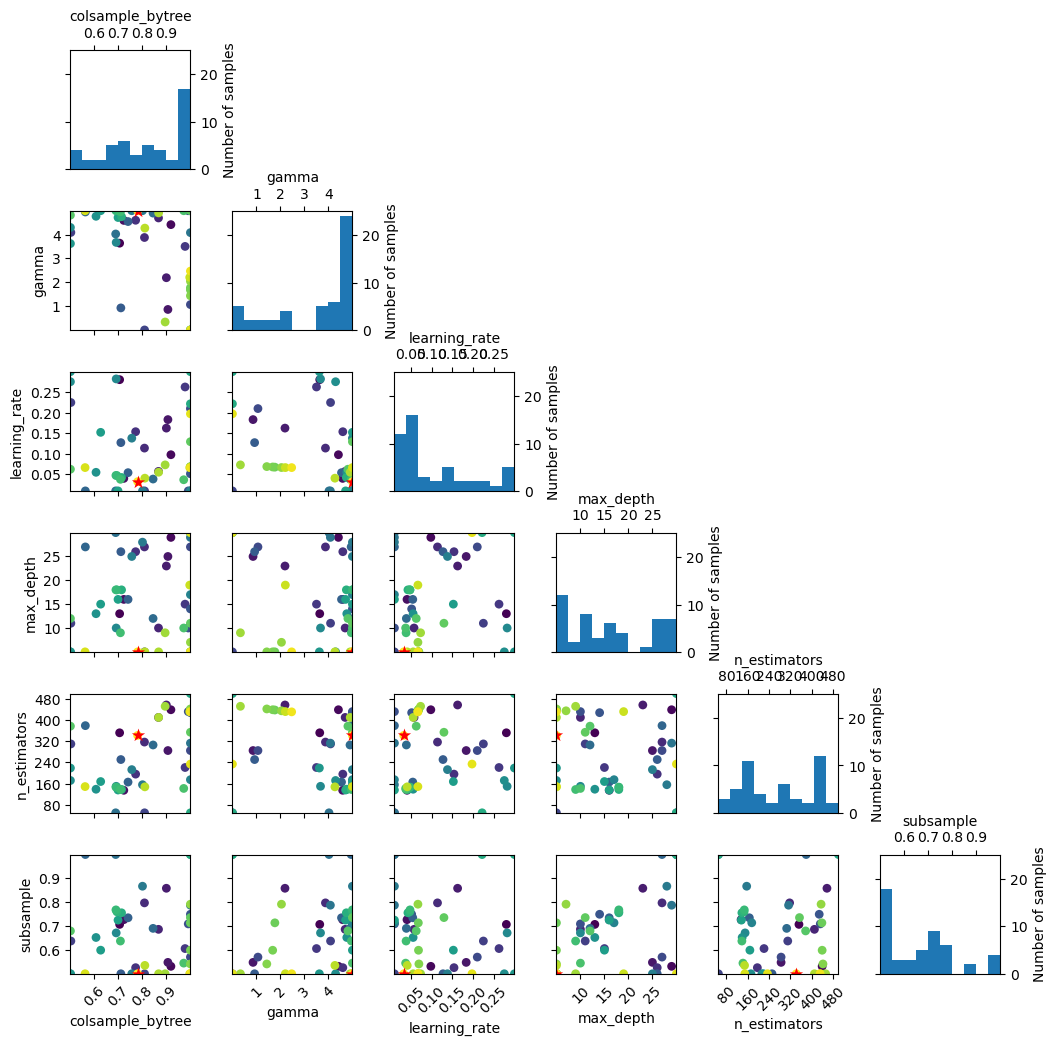

In [16]:
from skopt.plots import plot_evaluations

plot_evaluations(bayes_search.optimizer_results_[0], bins=10)
plt.show()

Let's visualize parameter distributions next

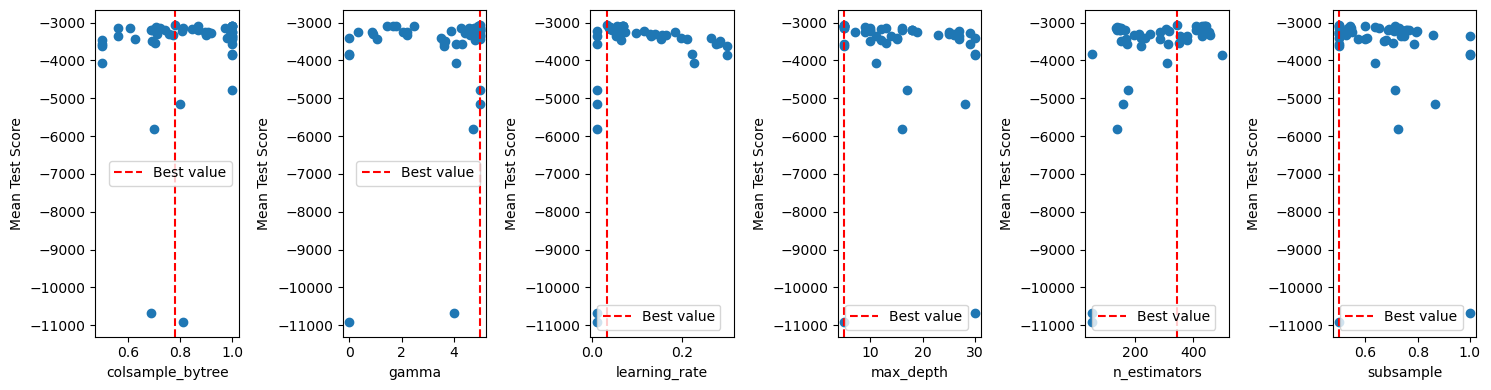

In [17]:
# Get hyperparameter names from BayesSearchCV's search_spaces
results = bayes_search.cv_results_
best_params = bayes_search.best_params_

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create plots for each parameter
fig, axes = plt.subplots(1, len(best_params), figsize=(15, 4))
params = list(best_params.keys())

for i, param in enumerate(params):
    param_name = f'param_{param}'
    # Extract parameter values
    param_values = results_df[param_name].values
    
    # Scatter plot: parameter value vs performance
    axes[i].scatter(param_values, results_df['mean_test_score'])
    axes[i].set_xlabel(param)
    axes[i].set_ylabel('Mean Test Score')
    axes[i].axvline(best_params[param], color='r', linestyle='--', label='Best value')
    axes[i].legend()

plt.tight_layout()
plt.show()

#### Next Steps for Hyperparameter Tuning

**Refine Search Space**

- Based on scatter plots, focus tuning on the most promising regions:
  - `learning_rate`: 0.01–0.1 (red stars clustered around 0.05)
  - `n_estimators`: 50–200 (indicated by clustering and red stars)
  - `max_depth`: 5–15 (majority of samples fall in this range)
  - `subsample`: 0.6–0.9
  - `colsample_bytree`: 0.6–0.9
  - `gamma`: 0–2 (most samples are below 2)

- Narrowing the hyperparameter space **reduces computational cost** and concentrates the search on **high-performing regions**.


**Increase Iterations**

- The convergence plot suggests the search may have stabilized, but increasing the number of iterations (e.g., `n_iter=75`) within the refined space could help confirm the optimum.


In [20]:
%%time
# refine the search space for Bayesian optimization
search_space = {
    'n_estimators': Integer(50, 500),
    'max_depth': Integer(5, 15),
    'learning_rate': Real(0.01, 0.1, prior='uniform'),
    'subsample': Real(0.6, 0.9, prior='uniform'),
    'colsample_bytree': Real(0.6, 0.9, prior='uniform'),
    'gamma': Real(0, 2, prior='uniform'),
}

# define the model
xgb = XGBRegressor(objective='reg:squarederror', enable_categorical=True, random_state=42)
# define the Bayesian optimization search
bayes_search = BayesSearchCV(
    xgb,
    search_space,
    n_iter=75,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=0
)
# fit the model
bayes_search.fit(X_train, y_train)

CPU times: total: 1min 37s
Wall time: 2min 59s


BayesSearchCV(cv=3,
              estimator=XGBRegressor(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None...
                             'gamma': Real(low=0, high=2, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.01, high=0.1, prior='uniform', transform='normalize'),
                             'max_depth': Integer(low=5, high=15, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=0.9, prior='uniform', transform='normalize')})

In [21]:
print('Bayesian Optimization Results: ')
# get the best parameters
best_params_bayes = bayes_search.best_params_
print('Best Parameters: ')
print(best_params_bayes)
# get the best score
best_score_bayes = bayes_search.best_score_
print('Best CV Score: ', best_score_bayes)
# make predictions
y_pred_bayes = bayes_search.predict(X_test)
# calculate the RMSE
rmse_bayes = root_mean_squared_error(y_test, y_pred_bayes)
print('Test RMSE: ', rmse_bayes)
# calculate the R2 score
r2_bayes = r2_score(y_test, y_pred_bayes)
print('Test R2: ', r2_bayes)


Bayesian Optimization Results: 
Best Parameters: 
OrderedDict({'colsample_bytree': 0.60000489767951, 'gamma': 1.3194686223941245, 'learning_rate': 0.024138854425252557, 'max_depth': 6, 'n_estimators': 409, 'subsample': 0.6717795261110148})
Best CV Score:  -2997.3878580729165
Test RMSE:  3131.67626953125
Test R2:  0.9665706753730774


As can be seen, the test RMSE was further reduced after incorporating these steps.

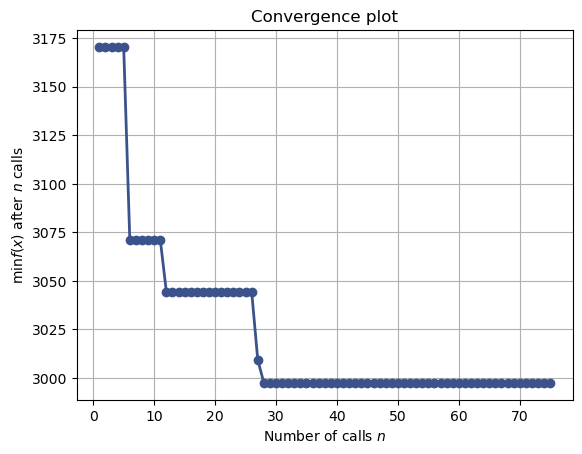

In [23]:
# plot objective function
bayes_res = bayes_search.optimizer_results_[0]
plot_convergence(bayes_res)
plt.show()

With 75 iterations, the search appears sufficient, as the objective value stabilizes

Alternatively, consider switching to **`Optuna`**, which offers advanced features like **pruning**, allowing it to stop unpromising trials early and focus computational effort on more promising regions of the search space.

**Optuna** is often the preferred choice for tuning tree-based models such as **XGBoost**, **LightGBM**, and **CatBoost**, thanks to its intelligent **Tree-structured Parzen Estimator (TPE)** search algorithm and efficient pruning strategy.


### 2. `Optuna` (Advanced TPE-Based Optimization)

`Optuna` is a modern hyperparameter optimization framework that uses Tree-structured Parzen Estimator (TPE) and **pruning** to efficiently explore the hyperparameter space.

- **How it works**: Models the hyperparameter space probabilistically and prioritizes promising combinations, stopping unpromising trials early (**pruning**).

- **Pros**:
  - **Highly efficient** due to pruning, saving compute time for expensive models like boosting trees.
  - Flexible, supporting dynamic search spaces and easy integration with XGBoost, LightGBM, and CatBoost.
  - Often finds better hyperparameters with **fewer trials** compared to `RandomizedSearchCV`.

- **Cons**:
  - Requires slightly more setup (e.g., defining an objective function) than scikit-learn tools.

- **Library**: `optuna`.

- **Use Case**: Best for most boosting model tasks, especially with **large datasets** or **complex hyperparameter spaces**.

In [27]:
%%time
# use optuna
import optuna
from sklearn.model_selection import cross_val_score
from optuna import create_study

def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)

    # Create the model
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        objective='reg:squarederror',
        enable_categorical=True,
        random_state=42
    )

    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error')
    
    return -scores.mean()

# Create a study object
study = create_study(direction='minimize')
# Optimize the objective function
study.optimize(objective, n_trials=50)

[I 2025-05-18 14:07:55,357] A new study created in memory with name: no-name-f3ce2686-4303-4134-ba07-01df44899c17
[I 2025-05-18 14:07:57,058] Trial 0 finished with value: 3331.6385904947915 and parameters: {'n_estimators': 110, 'max_depth': 13, 'learning_rate': 0.18884203283886744, 'subsample': 0.5854526666440897, 'colsample_bytree': 0.8937738801429804, 'gamma': 2.6946659405421385}. Best is trial 0 with value: 3331.6385904947915.
[I 2025-05-18 14:08:07,356] Trial 1 finished with value: 3532.982177734375 and parameters: {'n_estimators': 405, 'max_depth': 24, 'learning_rate': 0.16910832412869004, 'subsample': 0.9737607498458992, 'colsample_bytree': 0.5976945917277403, 'gamma': 2.817167693022663}. Best is trial 0 with value: 3331.6385904947915.
[I 2025-05-18 14:08:14,607] Trial 2 finished with value: 3277.841552734375 and parameters: {'n_estimators': 149, 'max_depth': 17, 'learning_rate': 0.04812097737053897, 'subsample': 0.9546726621457335, 'colsample_bytree': 0.8450595576069481, 'gamma'

CPU times: total: 25min 51s
Wall time: 4min 39s


In [28]:
print('Optuna Optimization Results: ')
# get the best parameters
best_params_optuna = study.best_params
print('Best Parameters: ')
print(best_params_optuna)
# get the best score
best_score_optuna = study.best_value
print('Best CV Score: ', best_score_optuna)


Optuna Optimization Results: 
Best Parameters: 
{'n_estimators': 466, 'max_depth': 6, 'learning_rate': 0.03084135866822044, 'subsample': 0.502564756808311, 'colsample_bytree': 0.6563931619463742, 'gamma': 4.887027549415513}
Best CV Score:  2990.7191569010415


In [29]:
# retrain the model with the best parameters
best_model = XGBRegressor(
    **best_params_optuna,
    objective='reg:squarederror',
    enable_categorical=True,
    random_state=42
)
# fit the model
best_model.fit(X_train, y_train)
# make predictions
y_pred_optuna = best_model.predict(X_test)
# calculate the RMSE
rmse_optuna = root_mean_squared_error(y_test, y_pred_optuna)
print('Test RMSE: ', rmse_optuna)
# calculate the R2 score
r2_optuna = r2_score(y_test, y_pred_optuna)
print('Test R2: ', r2_optuna)

Test RMSE:  3096.413818359375
Test R2:  0.9673192501068115


Let's visualize the tuning 

In [38]:
import optuna.visualization as vis
import plotly.io as pio

# Generate figures
fig1 = vis.plot_optimization_history(study)
fig1.show()
fig2 = vis.plot_param_importances(study)
fig2.show()
fig3 = vis.plot_slice(study)
fig3.show()




Enable Optuna parallel trials with `n_jobs=-1`

In [49]:
%%time

def objective(trial):
    # Define the hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)

    # Create the model
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        objective='reg:squarederror',
        enable_categorical=True,
        random_state=42
    )

    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='neg_root_mean_squared_error')
    
    return -scores.mean()

parallel_study = create_study(direction='minimize')
parallel_study.optimize(objective, n_trials=50, n_jobs=-1)

[I 2025-05-18 14:34:24,598] A new study created in memory with name: no-name-8c4110c7-8504-4b30-8239-4ca7a887a77e
[I 2025-05-18 14:34:44,688] Trial 3 finished with value: 3386.8870442708335 and parameters: {'n_estimators': 186, 'max_depth': 7, 'learning_rate': 0.016917121150508863, 'subsample': 0.6205391387487309, 'colsample_bytree': 0.9226243614668972, 'gamma': 0.7198073118252574}. Best is trial 3 with value: 3386.8870442708335.
[I 2025-05-18 14:34:51,587] Trial 15 finished with value: 3225.1217447916665 and parameters: {'n_estimators': 336, 'max_depth': 5, 'learning_rate': 0.22071165224743958, 'subsample': 0.9479603262439835, 'colsample_bytree': 0.633493959052336, 'gamma': 4.219844381569382}. Best is trial 15 with value: 3225.1217447916665.
[I 2025-05-18 14:34:56,685] Trial 0 finished with value: 3780.4537760416665 and parameters: {'n_estimators': 75, 'max_depth': 28, 'learning_rate': 0.08734595383748141, 'subsample': 0.643816201392093, 'colsample_bytree': 0.5096005859401787, 'gamma'

CPU times: total: 26min 6s
Wall time: 3min 27s


The wall time was shortened from 4 minutes 39 seconds to 3 minutes 27 seconds, a reduction of 1 minute 12 seconds for this small dataset.

In [50]:
# retrain the model with the best parameters
best_model = XGBRegressor(
    **best_params_optuna,
    objective='reg:squarederror',
    enable_categorical=True,
    random_state=42
)
# fit the model
best_model.fit(X_train, y_train)
# make predictions
y_pred_optuna = best_model.predict(X_test)
# calculate the RMSE
rmse_optuna = root_mean_squared_error(y_test, y_pred_optuna)
print('Test RMSE: ', rmse_optuna)
# calculate the R2 score
r2_optuna = r2_score(y_test, y_pred_optuna)
print('Test R2: ', r2_optuna)

Test RMSE:  3096.413818359375
Test R2:  0.9673192501068115


The result is the same

Optuna supports multiple optimization strategies, with TPE as the default. You can customize its optimization behavior by selecting different samplers. The default settings are robust and adaptive, so for most practical use cases, tuning Optuna’s internal configuration is not necessary.

## AutoML (Fast and Lightweight AutoML)

**FLAML** is a lightweight and efficient AutoML library developed by Microsoft Research. It’s designed for fast and economical hyperparameter optimization and model selection without relying on expensive Bayesian optimization.

you need to install FLAML

```python
pip install flaml
```

In [51]:
pip install flaml

   ---------------------------------------- 0.0/314.2 kB ? eta -:--:--
   - -------------------------------------- 10.2/314.2 kB ? eta -:--:--
   -------------------- ------------------- 163.8/314.2 kB 2.5 MB/s eta 0:00:01
   ---------------------------------------  307.2/314.2 kB 3.8 MB/s eta 0:00:01
   ---------------------------------------- 314.2/314.2 kB 2.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [54]:
# setup flaml
from flaml import AutoML

settings = {
    "time_budget": 240,  # in seconds
    "metric": 'rmse',
    "task": 'regression',
    "log_file_name": 'flaml.log',
}

automl = AutoML()
automl.fit(X_train, y_train, **settings)
# make predictions
y_pred_flaml = automl.predict(X_test)
# calculate the RMSE
rmse_flaml = root_mean_squared_error(y_test, y_pred_flaml)
print('Test RMSE: ', rmse_flaml)
# calculate the R2 score
r2_flaml = r2_score(y_test, y_pred_flaml)
print('Test R2: ', r2_flaml)
# get the best model
best_model_flaml = automl.model.estimator
# get the best parameters
best_params_flaml = automl.best_config
print('Best Parameters: ')
print(best_params_flaml)
# get the best score
best_score_flaml = automl.best_loss
print('Best CV Score: ', best_score_flaml)
# get the best estimator

[flaml.automl.logger: 05-18 15:00:23] {1728} INFO - task = regression
[flaml.automl.logger: 05-18 15:00:23] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 05-18 15:00:23] {1838} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 05-18 15:00:23] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'catboost']
[flaml.automl.logger: 05-18 15:00:23] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 05-18 15:00:23] {2393} INFO - Estimated sufficient time budget=1953s. Estimated necessary time budget=17s.
[flaml.automl.logger: 05-18 15:00:23] {2442} INFO -  at 0.2s,	estimator lgbm's best error=12968.4586,	best estimator lgbm's best error=12968.4586
[flaml.automl.logger: 05-18 15:00:23] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 05-18 15:00:23] {2442} INFO -  at 0.4s,	estimator lgbm's best error=12968.4586,	best estimator lgbm's best error=12968.4586
[flaml.automl.log

**FLAML** is well-suited for quick AutoML tasks on small- to medium-sized datasets. Compared to tools like **Optuna** (which offers flexible search and pruning) and **BayesSearchCV** (which integrates tightly with scikit-learn), FLAML prioritizes **speed**, **efficiency**, and **minimal configuration**.

In contrast, there are also **fully-managed cloud AutoML services**, which handle the entire pipeline from data preprocessing to deployment. These services are convenient but come with usage costs.

**Fully-Managed Cloud AutoML Services**

| **Platform** | **Product Name**         |
|--------------|--------------------------|
| GCP          | Vertex AI AutoML         |
| AWS          | SageMaker Autopilot      |

> ⚠️ Note: These cloud-based AutoML platforms are **not free** — you pay for compute, storage, and usage time.

CV-based hyperparameter tuning often leads to better model performance than generic cloud AutoML — especially when you know what you're doing.

## Resources

* Optuna paper
* Optuna github repo
* scikit-optimize offcial website
* scikit-optimize github repo
* FLAML GitHub

* Official Docs

* AutoML Benchmark Paper